# Homework: Not So Basic Artificial Neural Networks

Your task is to implement a simple framework for convolutional neural networks training. While convolutional neural networks is a subject of lecture 3, we expect that there are a lot of students who are familiar with the topic.

In order to successfully pass this homework, you will have to:

- Implement all the blocks in `homework_modules.ipynb` (esp `Conv2d` and `MaxPool2d` layers). Good implementation should pass all the tests in `homework_test_modules.ipynb`.
- Settle with a bit of math in `homework_differentiation.ipynb`
- Train a CNN that has at least one `Conv2d` layer, `MaxPool2d` layer and `BatchNormalization` layer and achieves at least 97% accuracy on MNIST test set.

Feel free to use `homework_main-basic.ipynb` for debugging or as source of code snippets. 

Note, that this homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook with cnn trained
- `homework_modules.ipynb`
- `homework_differentiation.ipynb`

In [49]:
%matplotlib inline
from time import time, sleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# (re-)load layers
%run homework_modules.ipynb

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [18]:
from sklearn.preprocessing import OneHotEncoder
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()  # your dataset

# Add fake dimensions for channels in images
X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

# One hot encoding
y_train = np.expand_dims(y_train, axis=1)
y_val = np.expand_dims(y_val, axis=1)
y_test = np.expand_dims(y_test, axis=1)

enc = OneHotEncoder().fit(y_train)

y_train = enc.transform(y_train).toarray()
y_val = enc.transform(y_val).toarray()
y_test = enc.transform(y_test).toarray()

In [29]:
criterion = ClassNLLCriterion()

def train(model, train_x, train_y, val_x, val_y, batch_size, n_epoch,  
          optimizer_config, optimizer = sgd_momentum, visualize=False):
    loss_history = []
    validate_history = []
    optimizer_state = {}
    
    for i in range(n_epoch):
        # Train the model
        model.train()
        for x_batch, y_batch in get_batches((train_x, train_y), batch_size):
            
            model.zeroGradParameters()
            
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Update weights
            optimizer(model.getParameters(), 
                        model.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
            
            loss_history.append(loss)
            print(loss)

        # Visualize
        display.clear_output(wait=True)

        if visualize:
            plt.figure(figsize=(8, 6))
                
            plt.title("Training loss")
            plt.xlabel("#iteration")
            plt.ylabel("loss")
            plt.plot(loss_history, 'b')
            plt.show()
         
        # Validation
        model.evaluate()
        predictions = np.exp(model.forward(val_x)).argmax(axis=1)
        truth = val_y.argmax(axis=1)
        acc = (predictions == truth).mean()
        validate_history.append(acc)
        
        print(f'Epoch {i+1}/{n_epoch}: Training loss {loss:.4f}. Validation accuracy: {acc:.4f}')
                
    return loss_history, validate_history

Print here your accuracy on test set. It should be >97%. Don't forget to switch the network in 'evaluate' mode

In [45]:
net = Sequential()
net.add(Conv2d(1, 4, 5))
net.add(ReLU())
net.add(MaxPool2d(2))
net.add(Conv2d(4, 8, 5))
net.add(ReLU())
net.add(MaxPool2d(2))
net.add(Conv2d(8, 8, 5))
net.add(ReLU())  
net.add(Flatten())
net.add(Linear(392,10))
net.add(LogSoftMax())   

BATCH_SIZE = 128
N_EPOCHS = 25
optimizer_config = {'learning_rate' : 1e-2, 'beta1':0.9, 'beta2':0.999, 'epsilon': 1e-3}
loss, acc = train(net, X_train, y_train, X_val, y_val, BATCH_SIZE, N_EPOCHS, 
                  optimizer_config, optimizer=adam_optimizer)

Epoch 25/25: Training loss 0.0041. Validation accuracy: 0.9801


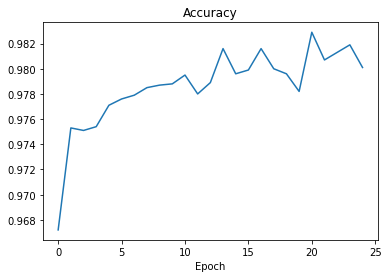

In [54]:
accuracy = pd.DataFrame(acc)
accuracy.index.name = 'Epoch'
accuracy.plot(title='Accuracy', legend=False)

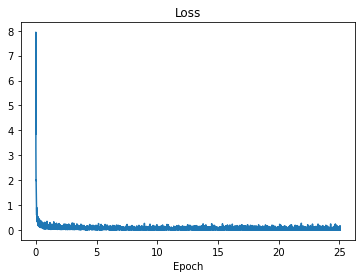

In [57]:
loss = pd.DataFrame(loss)
loss.index = loss.index/390
loss.index.name = 'Epoch'
loss.plot(title='Loss', legend=False)

In [61]:
net.evaluate()
predictions = np.exp(net.forward(X_test)).argmax(axis=1)
truth = y_test.argmax(axis=1)
test_acc = (predictions == truth).mean()

print(f'Test set accuraccy: {test_acc:.5f}')

Test set accuraccy: 0.97820


OK, so I forgot to add a `BatchNorm` layer... But whatever, still got the desired accuracy!